In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm
import pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

import pandas as pd
from sympy import parse_expr, lambdify

import torch
import torch.nn as nn

In [2]:
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)
x_i_test = np.random.uniform(low=-1, high=1, size=(10000, 1))
x_i_test = torch.from_numpy(x_i_test).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
).to(device)

with torch.no_grad():
    y_i = teacher(x_i)
    y_i_test = teacher(x_i_test)

results = dict()

lr = 1e-3

results[lr] = dict()
results[lr]['train'] = list()
results[lr]['test'] = list()
results[lr]['times'] = list()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 

width = 40
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

results[lr]['start_time'] = time.time()
for _ in tqdm(range(30000), leave=False):
    optim.zero_grad()
    y_pred = mlp(x_i)
    l = loss_fn(y_pred, y_i)
    with torch.no_grad():
        results[lr]['times'].append(time.time())
        results[lr]['train'].append(np.sqrt(l.item()))
        results[lr]['test'].append(rmse_loss_fn_torch(mlp(x_i_test), y_i_test).item())
    l.backward()
    optim.step()


  0%|          | 0/30000 [00:00<?, ?it/s]

In [3]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hessian_autograd(model, loss_fn, x, y):
    H = torch.autograd.functional.hessian(get_func(model, loss_fn, x, y), tuple(model.parameters()))
    return H

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

def decompose_hessian(hessian, lengths, shapes):
    H_matrix = torch.zeros(sum(lengths), sum(lengths))
    for i, j in product(range(len(shapes)), range(len(shapes))):
        i0, i1 = sum(lengths[:i+1]) - lengths[i], sum(lengths[:i+1])
        j0, j1 = sum(lengths[:j+1]) - lengths[j], sum(lengths[:j+1])
        H_matrix[i0:i1, j0:j1] = hessian[i][j].reshape(lengths[i], lengths[j])
    vals, vecs = torch.linalg.eigh(H_matrix)
    vs = []
    for i in range(sum(lengths)):
        vec = vecs[:, i]
        v = tuple(vec[sum(lengths[:i]):sum(lengths[:i+1])].reshape(shapes[i]) for i in range(len(lengths)))
        vs.append(v)
    return vals, vs

def dot_prod(u, v):
    assert len(u) == len(v)
    result = 0
    for i in range(len(u)):
        result += torch.sum(u[i] * v[i])
        return result.item()
    
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss



In [4]:
params = []
shapes = []
lengths = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

mlp.zero_grad()

# for j, p in enumerate(mlp.parameters()):
#     p.data = solution_params[j].clone()

hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lengths, shapes)
mlp.zero_grad()

mse_loss_fn_torch(mlp(x_i), y_i).backward()
g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

pos_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] >= 0]
neg_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] < 0]
pos_dot_prods.reverse()
neg_dot_prods.reverse()

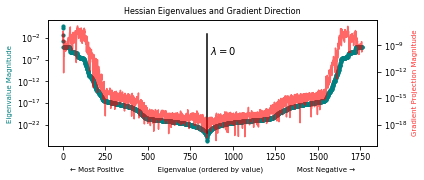

In [44]:
plt.figure(figsize=(6.0, 2.6))

ax1 = plt.subplot(1, 1, 1)
ax1.scatter(list(range(len(positives + negatives))), positives + np.abs(negatives).tolist(), color='teal', s=10)
ax1.set_yscale('log')
ax1.set_title("Hessian Eigenvalues and Gradient Direction", fontsize=8)
ax1.set_ylabel("Eigenvalue Magnitude ", fontsize=7, color='teal')
ax1.set_xlabel("← Most Positive               Eigenvalue (ordered by value)               Most Negative →", fontsize=7)
ax2 = ax1.twinx()
ax2.plot(list(range(len(positives + negatives))), pos_dot_prods+neg_dot_prods, color='red', alpha=0.6)
ax2.set_yscale('log')
ax2.set_ylabel('Gradient Projection Magnitude', fontsize=7, color='red', alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax1.plot([len(positives), len(positives)], [1e-1, 1e-24], color='black')
ax1.text(len(positives)+20, 1e-6, r"$\lambda = 0$")

# ax1 = plt.subplot(1, 2, 2)
# ax1.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives), color='teal', s=10)
# ax1.set_yscale('log')
# ax1.set_title("Negative eigenvalues", fontsize=8)
# ax1.set_ylabel("Negative Eigenvalue Magnitude", fontsize=7, color='teal')
# ax1.set_xlabel("Eigenvalue (ordered by value)", fontsize=7)
# ax2 = ax1.twinx()
# ax2.plot(list(range(len(positives), len(positives) + len(negatives))), neg_dot_prods, color='red', alpha=0.6)
# ax2.set_yscale('log')
# ax2.set_ylabel('Gradient Projection Magnitude', fontsize=7, color='red', alpha=0.8)

# plt.suptitle("After training:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)), fontsize=8)

plt.tight_layout()
plt.savefig('../final-figures/eigenvalue-spectrum-teacher-student-with-projection-adam-full.pdf')